# Regrid example

In [1]:
#data handling
import xesmf as xe
import xarray
import numpy

In [2]:
#plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
#import my functions
import sys
sys.path.append('../')
import helpers.fileHandler as fh


In [4]:
#defs
secondsPerDay = 60*60*24

Load up the precip data from a model

In [5]:
prXr=fh.loadModelData('CESM2', 'pr_Amon', 'piControl', 'r1i1p1f1').pr*secondsPerDay

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [6]:
prXr

<xarray.DataArray 'pr' (time: 14400, lat: 192, lon: 288)>
dask.array<mul, shape=(14400, 192, 288), dtype=float64, chunksize=(1212, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0001-01-16 00:00:00 ... 1200-12-16 00:00:00

grab area around Australia

In [7]:
domainXr=prXr.where(
        (prXr.lat>-50) & (prXr.lat<0) & (prXr.lon>100) & (prXr.lon<170),
        drop=True
    )

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [8]:
domainXr

<xarray.DataArray 'pr' (time: 14400, lat: 53, lon: 55)>
dask.array<where, shape=(14400, 53, 55), dtype=float64, chunksize=(1212, 53, 55), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -49.48 -48.53 -47.59 -46.65 ... -2.356 -1.414 -0.4712
  * lon      (lon) float64 101.2 102.5 103.8 105.0 ... 165.0 166.2 167.5 168.8
  * time     (time) object 0001-01-16 00:00:00 ... 1200-12-16 00:00:00

sanity check the area looks right

In [9]:
da=domainXr.isel(time=0).compute()

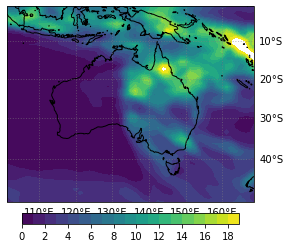

In [10]:
precContours=numpy.arange(0,20,1)

fig=plt.figure()

ax=plt.subplot(projection=ccrs.Miller())

#do the plotting
cs=plt.contourf(
                da.lon, da.lat, da.values, precContours, 
                transform=ccrs.PlateCarree()
               )
ax.coastlines(color='black')

gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.top_labels=False
gl.left_labels=False
    
    
cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)
    

define a new grid that we want to regrid to.

this is based on the Grose et al 2021 grid choice

In [12]:
regridXr=xarray.Dataset(
                    {
                        'lat': (['lat'], numpy.arange(-50, 0, 1.5)),
                        'lon': (['lon'], numpy.arange(100, 170, 1.5)),
                    }
                   )
regridXr

<xarray.Dataset>
Dimensions:  (lat: 34, lon: 47)
Coordinates:
  * lat      (lat) float64 -50.0 -48.5 -47.0 -45.5 -44.0 ... -5.0 -3.5 -2.0 -0.5
  * lon      (lon) float64 100.0 101.5 103.0 104.5 ... 164.5 166.0 167.5 169.0
Data variables:
    *empty*

set up the regridder 

In [13]:
regridder = xe.Regridder(domainXr, regridXr, 'bilinear')
regridder  # print basic regridder information.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_53x55_34x47.nc 
Reuse pre-computed weights? False 
Input grid shape:           (53, 55) 
Output grid shape:          (34, 47) 
Periodic in longitude?      False

do the re grid

In [14]:
resultXr=regridder(domainXr)

As I've used a released function for the regrid, I am not going to test the result (I'll assume the function has been tested).

For sanity, check the following:
- new lat/lon matches expected co-ords from regridXr
- input and output times are unchanged
- plots for time=0 look similar

In [14]:
resultXr

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'pr' (time: 14400, lat: 34, lon: 47)>
dask.array<transpose, shape=(14400, 34, 47), dtype=float64, chunksize=(1212, 34, 47), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-01-16 00:00:00 ... 1200-12-16 00:00:00
  * lon      (lon) float64 100.0 101.5 103.0 104.5 ... 164.5 166.0 167.5 169.0
  * lat      (lat) float64 -50.0 -48.5 -47.0 -45.5 -44.0 ... -5.0 -3.5 -2.0 -0.5
Attributes:
    regrid_method:  bilinear

In [17]:
regridXr.lat.equals(resultXr.lat)

True

In [18]:
regridXr.lon.equals(resultXr.lon)

True

In [19]:
prXr.time.equals(resultXr.time)

True

plot it again, see if it still looks the same

In [15]:
da=resultXr.isel(time=0).compute()

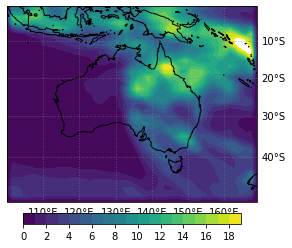

In [16]:
fig=plt.figure()

ax=plt.subplot(projection=ccrs.Miller())

#do the plotting
cs=plt.contourf(da.lon, da.lat, da.values, precContours, 
                transform=ccrs.PlateCarree(), #cmap=cmap, extend='both'
               )
ax.coastlines(color='black')

gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.top_labels=False
gl.left_labels=False
    
cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)
